# Starbucks Capstone Challenge

## 1. Project Definition

### 1.1 Project Overview
This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



In [381]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### 1.2  Problem Statement

Idealy, I would like to know from the data which peole are more likely to respon to offers. Maximum level of engagement is that people recieved the offer, viewed it and completed it. This will help to know who to target with what type of offer in Starbuck marketing efforts which subsequently improve sales. The expected solution is a model that predict the customer response to an offer. Responding to offer will be defined as either vieweing or completing the offer. If the customer recieved the offer but did not view it or complete it, this will be considered as not responding.

**Strategy to solve the problem**:

I will develop 3 models namely 

- AdaBoosting model
- Randomforst model 
- Bagging model 



In addtion I will explore the hurestic approach, below are number of questions I will try to answer using the data. 

  - Which people are more likely than others to respond to offers, using their demographic characteristics.?
      - what is the success rate of offers sent across gender? 
      - what is the success rate of offers sent across gender and offer types? 
      - what is the success rate of offers sent across age?  
      


### 1.3 Metrics

Since the problem defined is a binary classification problem. Accuracy and F1-scire Metrics will be used to to measure performance of the models. 

# 2. Analysis

### 2.1 Data Exploration


##### Exploring the Profile dataset 

In [83]:
profile.shape

(17000, 5)

In [84]:
len(profile.id.unique())

17000

**Note** We have 17000 unique users and 5 attributes about each. 

In [85]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


**Notes**: age include strange values of `118`. Normally, this could be mis-entry or a unique value for missing values. My initial suspecion is that `118` was used to indicate for missing values  by looking at both *gender* and *Income* columns

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


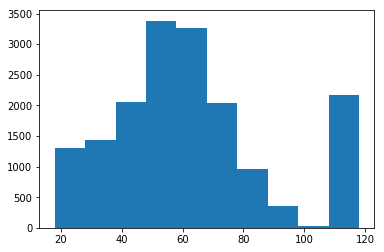

In [86]:
plt.hist(profile.age); profile.describe()

**Analysis:** except for the abnormal value of 118, the shape of the age data is a normal distribution. It is interesting that the median age is 57 given that those data are simulated from the useage of Starbuck app platform. I was expecting a right skewed distribution.

**Next:** I would like to see if this distribution is different across gender

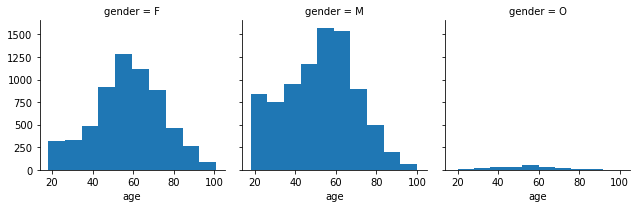

In [87]:
g1= sns.FacetGrid(profile, col="gender")
g1.map(plt.hist, "age")

**Analysis:** The same distribution holds across different genders. The slight difference is that the data has more younger males than females. 

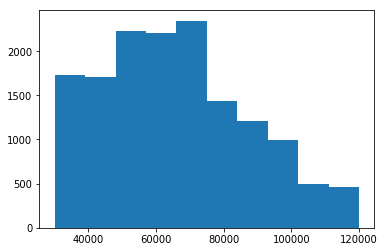

In [88]:
# Income Distribution, We had to drop the na values. 
plt.hist(profile.income[profile.income.notna()]);

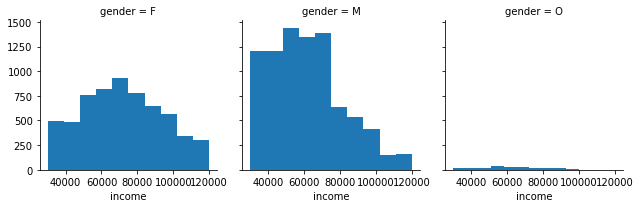

In [89]:
g1= sns.FacetGrid(profile, col="gender")
g1.map(plt.hist, "income")

**Analysis:** the distribution of income make perfect sense and it reconcile with the age distribution. The shape of level of income for females is normal distribution which memic the shape of age.

on the other hand level of income for males are right skewed because the data has more young males than females which confirm our understanding. 

**Next:** I would like to how many missing data we have. Moreover, I would like to check if 118 for age is a unique value for missing data. 

In [90]:
profile.apply(axis=0,func=lambda x: x.isna().sum())

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [91]:
profile[profile.age != 118].isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

**Analysis:** As suspected the value of 118 is unique value to indicate missing data for age.

**Note**: I would not like to remove the customers with missing data just yet. It is important to see impact of removing them on the other datsets. For example, if large portion of the `transcript` datasets is about the activites for those customers we will lose a lot of good data when we merge it with the cleaned up `profile` datasets. instead we will store those ids in a pandas Series for later use.

In [92]:
missing_people = profile.loc[profile.age == 118,:].id

##### Exploring the portfolio dataset 

In [93]:
portfolio.shape

(10, 6)

In [94]:
len(portfolio.id.unique())

10

**Note** We have 10 unique offers with 5 attributes about each. 

In [95]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [96]:
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [97]:
portfolio.difficulty.unique()

array([10,  0,  5, 20,  7])

**Note:** There seem to be 3 types of offers and 5 levels of difficulties in the portfolio dataset. In addition the assumption here is that here are only four channels namely Email, Mobile, Web and Social.

**Next:** I would like to check if we have any missing data here

In [98]:
portfolio.apply(axis=0,func=lambda x: x.isna().sum())

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

**Note** It seems that we don't 

##### Exploring the transcript dataset 

In [99]:
transcript.shape

(306534, 4)

In [100]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [101]:
# Checking if all the users that we have information about have activity recorded in the data
np.sum(pd.Series(transcript.person.unique()).isin(pd.Series((profile.id.unique()))))

17000

In [102]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

**Note** We have 306534 activities that include all of the 17000 users. Those activities are 'offer received', 'offer viewed', 'transaction', 'offer completed' events. with time stamp since the start of the test. The idea here 

Moreover, it seems that we have to splilt the data into two datasets. one for offer response and the other for transactions. Transactions datasets might give us the level of spending for certain demographic groups. 

**Next** I would like to see how many offers were recieved and how many of them were viewed and how many of those were completed. 

In [103]:
transcript.groupby('event').count().loc[:,:'person']

,person
event,
offer completed,33579
offer received,76277
offer viewed,57725
transaction,138953


In [104]:
print('There were',transcript.groupby('event').count().loc['offer received','person'], 'offeres recieved and',
     transcript.groupby('event').count().loc['offer viewed','person'],'(',np.round(57725/76277, decimals=2)*100,'%) were viewed and',  
     transcript.groupby('event').count().loc['offer completed','person'],'(',np.round(33579/76277, decimals=2)*100,'%) were completed') 

There were 76277 offeres recieved and 57725 ( 76.0 %) were viewed and 33579 ( 44.0 %) were completed


**Analysis:** There were 76277 offeres recieved and 57725 ( 76.0 %) were viewed and 33579 ( 44.0 %) were completed. This is actually pretty good response rate. Hopefully we can extract some insight on what drive this response by combining it with the demographic info about users later.

**Note:** value column will need further processing to be able to extract offer ids to be used as a key for joining datasets with portfolio and users


# 3. Methodology

### 3.1 Data Preprocessing

While exploring the dataset we found Here we will convert the Channels to dummy variables to be used later in the analysis and model building.

#### Data Formating 

portfolio.json

    id (string) -  *I will rename this column to 'offer_id' to make all datasets consistents
    channels  - * I will unfold the lists into hot-encoding columns 
profile.json

    became_member_on (int) - We can unfold into three columns , days, months and years.
    gender (str) - I will hot encode them into three columns 'O', 'M', 'F'. 
    id (str) - *I will rename this column to 'offer_id' to make all datasets consistents
    income (float) - I will leave as is.

transcript.json

I am planning to breakdown this 

    event (str) - record description (ie transaction, offer received, offer viewed, etc.)
         - I will seperate the dataset into two. one for transactions and one for offers. 
             - Offer_dataset : I will hot-encode the events into three columns offer viewed,recieved, completed
             - spending_dataset: will have the information about the transactions for future analysis. 
            
    person (str) - leave as is
    time (int) - for simplification purposes discussed later this will be dropped. 
   

I will define three functions each will do the pre-processing for one of the dataset above. 


### 3.2 Implementation

The objective of creating the `success` binary variable is to engineer a target variable that can help us create a prediction model about the offers we have for different people. This also enable us to measure the performance of the model we create using **accuracy** or **f1-score.** 

#### Feature Engineering --  Offer_Success

**Note:** Knowing which offer is successful is a little bit tricky and requires some work. Success of the offer depends on the type of the offer. For example, if the offer is informational and the user viewed the offer, then the offer is successful. However, if the offer type is either "BOGO" or "Discount" then it is not enough if the user only viewed the offer. The user need to complete it as well. Here I am going to take a naive approach. using the matrix below 

`success` - Model 

| Offer Type     	| Offer_Recieved 	| Offer_viewed 	| Offer_completed 	| offer_success 	|
|----------------	|----------------	|--------------	|-----------------	|---------------	|
| Informational  	|        1       	|       1      	|       N/A       	| successful    	|
| Informational  	|        1       	|       0      	|       N/A       	| unsuccessful  	|
| BOGO           	|        1       	|       1      	|        1        	| successful    	|
| BOGO           	|        1       	|       1      	|        0        	| unsuccessful  	|
| Discount       	|        1       	|       1      	|        1        	| successful    	|
| Discount       	|        1       	|       1      	|        0        	| unsuccessful    	|


**Simplification**: 
 - if the **same** user responded to the **same** offer with the **same** offer type multiple times, I will consider this a success or fail only once. 
 

### Functions to do the preprocessing

**note:** I will do all the documentation through code comments to simplify the navigation for the reader

In [153]:
def clean_trascript(transcript_df): 
    """ 
    #    Clean up the transcript data frame and return it. 
    #    INPUT:
    #       transcript_df: all recoreded events on the user app

    #    
    #    OUTPUT:
    #        offer_dataset: a processed dataset for all the events related to the offers
    #        spending_dataset: a processed dataset for all the events related to the transactions
    """

    
    # Extracting the offers_id and amounts from the value columns of the data 
    transcript_clean = pd.DataFrame(transcript_df.value.tolist())
    
    # unify the name for offer id  
    transcript_clean.columns = transcript_clean.columns.str.replace("offer id","offer_id")
    s = transcript_clean.stack()
    transcript_clean = s.unstack()
    
    #Hot encode the offer event and merge it back to the dataset 
    transcript_clean = pd.get_dummies(data=transcript_clean.join(transcript_df),columns=['event'])
    
    # We can safely drop the value column now, we will also delete any duplicated records as a result of this process. 
    transcript_clean.drop('value', axis=1, inplace=True)
    transcript_clean.drop_duplicates(inplace=True)
    
    # We will segregate the offers and transactions into  different datasets. 
    offer_dataset = transcript_clean[transcript_clean.event_transaction != 1].copy()
    spending_dataset = transcript_clean[transcript_clean.event_transaction == 1].copy()
    
    # We will drop the unecessary columns from the offer_dataset 
    offer_dataset.drop(['amount','event_transaction','reward'], axis=1, inplace=True)
    
    # We will select the columns related to the spending behavior into a seperate dataset. 
    spending_dataset = spending_dataset.filter(['person', 'time', 'amount']).copy()


    return offer_dataset, spending_dataset.reset_index(drop=True)



In [154]:
def clean_portfolio(portfolio_df): 
    """ 
    #    Clean up the transcript data frame and return it. 
    #    INPUT:
    #       transcript_df: all recoreded events on the user app

    #    
    #    OUTPUT:
    #        offer_dataset: a processed dataset for all the events related to the offers
    #        spending_dataset: a processed dataset for all the events related to the transactions
    """
    
    # Extract and hot encode the channel useed for each offer 
    portfolio_clean = pd.concat([ portfolio_df,pd.get_dummies(portfolio_df.channels.apply(pd.Series).stack()).sum(level=0)], axis=1, sort=False)
    
    # we can savely drop channels and reward columns now 
    portfolio_clean.drop(['channels', 'reward'], axis=1, inplace=True)
    
    return portfolio_clean

In [257]:
def clean_profile(profile_df): 

    """ 
    Clean up the profile data frame and return it. This function also deals with missing data as discussed. 
    it also parse the date for membership into three columns , year, month , day 
    
    INPUT:
       profile_df: Data frame of containing the information related to users.

    #    
    OUTPUT:
        profile_df: a cleaned up Data Frame for all users on the app. 
    """
    # Deleting missing data [justification of decision is below]   
    profile_df = profile_df.loc[profile_df.age != 118]
    
    # Parsing the membership date into different Columns
    membership_column = profile_df.loc[:,('became_member_on')].astype(str)
    profile_df.loc[:,'member_year'] = membership_column.str[0:4].tolist()
    profile_df.loc[:,'member_month'] = membership_column.str[4:6].tolist()
    profile_df.loc[:,'member_day'] = membership_column.str[6:8].tolist()
    
    
     #Hot encode the gender and merge it back to the dataset 
    profile_df = pd.concat([profile_df, pd.get_dummies(profile_df.gender)],axis=1, sort=False)
    
    
    # Changing the id to person to make the dataset consistent with others. 
    profile_df.rename(columns={'id':'person'}, inplace=True)
    profile_df.drop(columns=['became_member_on', 'gender'], inplace=True)
    
    return profile_df
    

### 3.3 Refinement


#### Comming back to the people with missing values

We would like to know how much of the offers-dataset is for the people with missing values. I will calculate the percentage, if the portion is small I will simply remove them. 

In [203]:
offer_dataset,_ = clean_trascript(transcript)

In [204]:
offer_dataset.head()

,offer_id,person,time,event_offer completed,event_offer received,event_offer viewed
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,0,0,1,0
2,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0,0,1,0
3,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a49552598,0,0,1,0


In [205]:

print("Percent of missing data in the events database is {}".format(np.round(offer_dataset[offer_dataset.person.isin(missing_people)].shape[0]/offer_dataset.shape[0], decimals=2)*100), "%")

Percent of missing data in the events database is 11.0 %


**Note**: It's actually small portion. I will decided to drop them as including them will not add a lot 

In [258]:
def gen_analytic_df(cln_profile, cln_offer, cln_portfolio):
    """ 
    Merge users profiles with offered they encountered and offer information into one 
    analytical Data Frame 
    
    INPUT:
       cln_profile: cleaned up profile data frame. 
       cln_offer: cleaned up offer information (exclude transactions)
       cln_portfolio: cleaned up portfolio data frame. 

    #    
    OUTPUT:
        final_df: a processed dataset for all the events related to the offers
        spending_dataset: a processed dataset for all the events related to the transactions
    """
    
    cln_offer = cln_offer.groupby(["person","offer_id",]).sum().reset_index()
    offer_port = cln_offer.merge(cln_portfolio,left_on = 'offer_id', right_on = 'id').drop('id', axis = 1)
    offer_port.rename(columns={"event_offer received":"offer_recieved", "event_offer viewed":"offer_viewed",
                           "event_offer completed":"offer_completed"}, inplace = True)
    
    final_df  = offer_port.merge(cln_profile, on = "person").reset_index()
    
  
    
    
    return final_df

In [207]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [208]:
clean_portfolio(portfolio)

,difficulty,duration,id,offer_type,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,1,1,0,1


In [259]:
offer_dataset,_ = clean_trascript(transcript)
final_df = gen_analytic_df(clean_profile(profile), offer_dataset, clean_portfolio(portfolio))



In [152]:
final_df.head()

,person,offer_id,time,offer_completed,offer_recieved,offer_viewed,difficulty,duration,offer_type,email,...,social,web,age,income,member_year,member_month,member_day,F,M,O
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1152,1,1,0,10,7,discount,1,...,0,1,33,72000.0,2017,04,21,0,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,708,0,1,1,0,4,informational,1,...,0,1,33,72000.0,2017,04,21,0,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,360,0,1,1,0,3,informational,1,...,1,0,33,72000.0,2017,04,21,0,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1278,1,1,1,5,5,bogo,1,...,1,1,33,72000.0,2017,04,21,0,1,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1572,1,1,1,10,10,discount,1,...,1,1,33,72000.0,2017,04,21,0,1,0


### Implementing the offer_sucess analysis variable 

**Again** It's success if it meets the criteria below   

| Offer Type     	| Offer_Recieved 	| Offer_viewed 	| Offer_completed 	| offer_success 	|
|----------------	|----------------	|--------------	|-----------------	|---------------	|
| Informational  	|        1       	|       1      	|       N/A       	| successful    	|
| Informational  	|        1       	|       0      	|       N/A       	| unsuccessful  	|
| BOGO           	|        1       	|       1      	|        1        	| successful    	|
| BOGO           	|        1       	|       1      	|        0        	| unsuccessful  	|
| Discount       	|        1       	|       1      	|        1        	| successful    	|
| Discount       	|        1       	|       1      	|        0        	| unsuccessful    	|


In [380]:
def analyze_offer_success(df):
    
    """ 
    Analyze offer success based on the criteria provided in the note book. 
    
    INPUT:
       df: the analytical Data_frame we generated that has all the mereged datasets


    #    
    OUTPUT:
        final_df: Data_frame that has the success variable and cleaner DataFrame (Dropped unnecessary columns)
    """
    
    
    
    df.reset_index(drop=True)
    successful = []

    for i,item in df.iterrows():

        if(item['offer_type'] == 'informational'): 

            if(item["offer_recieved"] > 0) & (item["offer_viewed"] > 0): 
                successful.append(1)
            else: 
                successful.append(0)

        else:

            if (item["offer_recieved"] > 0) & (item["offer_viewed"] > 0) & (item['offer_completed'] > 0): 
                successful.append(1)

            else: 
                successful.append(0)
                
    final_df = pd.concat([df,pd.DataFrame(successful, columns=["success"])], axis=1)
    
    final_df.drop(columns=['offer_completed', 'offer_recieved', 'offer_viewed', 'time'], inplace=True)
    
    return final_df

In [260]:
analytic_df = analyze_offer_success(final_df)

In [261]:
analytic_df.head()

,index,person,offer_id,difficulty,duration,offer_type,email,mobile,social,web,age,income,member_year,member_month,member_day,F,M,O,success
0,0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,10,7,discount,1,1,0,1,33,72000.0,2017,04,21,0,1,0,0
1,1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,4,informational,1,1,0,1,33,72000.0,2017,04,21,0,1,0,1
2,2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,1,1,1,0,33,72000.0,2017,04,21,0,1,0,1
3,3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5,5,bogo,1,1,1,1,33,72000.0,2017,04,21,0,1,0,1
4,4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,10,10,discount,1,1,1,1,33,72000.0,2017,04,21,0,1,0,1


# 4. Results

### 4.1 Model Evaluation and Validation

### A. Heuristic Apporoach 



#### Question 1: what is the success rate of offers sent across gender?  

We will calculate the total number of each gender then use it as a normalizing factor for the success rate. then we calculate the number of success for each. Dividing them over each other gives us the rate for each. 

In [401]:
def get_graph_gender(df):
    """ 
    calculate the rate of success for each gender in a specified dataset. 
    
    INPUT:
       df:analytical Data_frame we generated that has all the mereged datasets


    #    
    OUTPUT:
        graph: list with values for the bargraph 
    """
    
        
    
    # Normalizaing factor 
    numb_F = df.loc[df.F == 1, 'success'].count()
    numb_M = df.loc[df.M == 1, 'success'].count()
    numb_O = df.loc[df.O == 1, 'success'].count()
    
    #Calculating success
    success_F = df.loc[df.F == 1, 'success'].sum()
    success_M = df.loc[df.M == 1, 'success'].sum()
    success_O = df.loc[df.O == 1, 'success'].sum()
    graph_data = [success_F/numb_F, success_M/numb_M, success_O/numb_O]
    return graph_data

In [341]:
graph_data = get_graph_gender(analytic_df)

Text(0.5, 1.0, 'All Offers Success across genders')

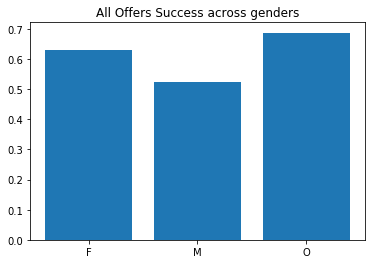

In [343]:
# Create bars
plt.bar(x=np.arange(3),height = graph_data)
# Create names on the x-axis
plt.xticks(np.arange(3), ['F', 'M', 'O']);
plt.title("All Offers Success across genders")

**Analysis:** It looks that the highest rate of 68% is for genders with 'Others'. Second in place comes Females. Males have the lowest success rate. Let's see if this pattern change accross different offer types. 

#### Question 2: what is the success rate of offers sent across gender and offer types?  

Let's see if this pattern change accross different offer types. Here I will plot the graph across all offers. 

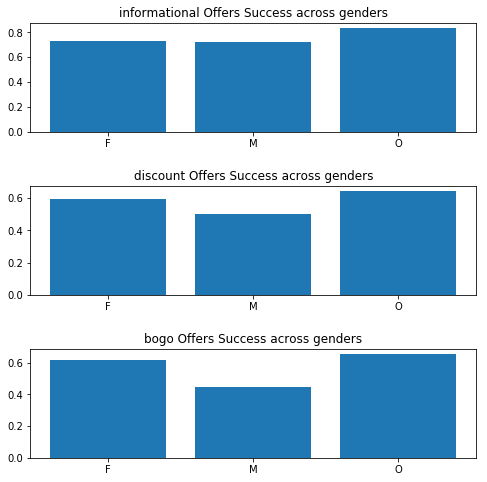

In [407]:


fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(8, 8))

ax1.bar(x=np.arange(3),height = get_graph_gender(analytic_df.loc[analytic_df.offer_type == "informational",:]))
ax1.set_title("informational Offers Success across genders")
ax2.bar(x=np.arange(3),height = get_graph_gender(analytic_df.loc[analytic_df.offer_type == "discount",:]))
ax2.set_title("discount Offers Success across genders")
ax3.bar(x=np.arange(3),height = get_graph_gender(analytic_df.loc[analytic_df.offer_type == "bogo",:]))
ax3.set_title("bogo Offers Success across genders")
ax1.set_xticks(np.arange(3)); ax1.set_xticklabels(['F', 'M', 'O'])
ax2.set_xticks(np.arange(3)); ax2.set_xticklabels(['F', 'M', 'O'])
ax3.set_xticks(np.arange(3)); ax3.set_xticklabels(['F', 'M', 'O'])
plt.subplots_adjust( hspace=.5)
plt.show()



**Analysis** : We can see from that data that Males are generally less responsive to offers. However, they are especially reluctant with "buy one get one" offers. On the other hand Females are very responsive to all types of offers in comparisons. 


#### Question 3: what is the success rate of offers sent across age?  


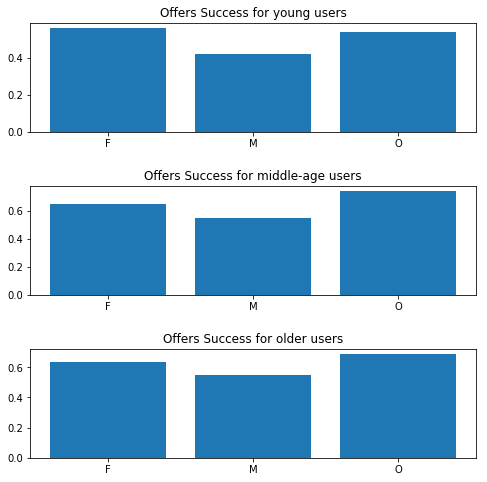

In [406]:
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(8, 8))

ax1.bar(x=np.arange(3),height = get_graph_gender(analytic_df.loc[(analytic_df.age <= 35) ,:]))
ax1.set_title("Offers Success for young users")
ax2.bar(x=np.arange(3),height = get_graph_gender(analytic_df.loc[(analytic_df["age"] > 35) & (analytic_df["age"] <= 55),:]))
ax2.set_title("Offers Success for middle-age users")
ax3.bar(x=np.arange(3),height = get_graph_gender(analytic_df.loc[(analytic_df.age > 55),:]))
ax3.set_title("Offers Success for older users")
ax1.set_xticks(np.arange(3)); ax1.set_xticklabels(['F', 'M', 'O'])
ax2.set_xticks(np.arange(3)); ax2.set_xticklabels(['F', 'M', 'O'])
ax3.set_xticks(np.arange(3)); ax3.set_xticklabels(['F', 'M', 'O'])
plt.subplots_adjust( hspace=.5)
plt.show()

**Analysis:** The general pattern presists across gender regardless of age or offer type. However, we can see significant  difference between the young males and females in how they respond to offers. Males are less responsive to offers. 


**note**: As we can tell from looking at these graphs.We can only come up with very general heuristics based on gender and age. This is not really bad finding but I believe we can do better by leverage the use of machine learning. 



### B. Model Apporoach 

As proposed at the begining of this analysis. I will develop 3 models to predict the success of an offer.

    - Bagging 
    - RandomForst
    - AdaBoosting
    
 I have chosen those models because they are very flexible and robust and useful for complicated datasets. 

## 4.1 Model Evaluation and Validation

In [392]:
# Instantiate a BaggingClassifier with:
# 200 weak learners (n_estimators) and everything else as default values

model_bagging = BaggingClassifier(n_estimators = 200)

# Instantiate a RandomForestClassifier with:
# 200 weak learners (n_estimators) and everything else as default values

model_randomForest = RandomForestClassifier(n_estimators = 200)

# Instantiate an a AdaBoostClassifier with:
# With 300 weak learners (n_estimators) and a learning_rate of 0.2

model_ada = AdaBoostClassifier(n_estimators = 300, learning_rate=0.2)

In [390]:
## Few pre-Processing before spliting the data. 
df = pd.concat([analytic_df,pd.get_dummies(analytic_df.offer_type)],axis = 1 ,sort=False)
df.reset_index(drop= True, inplace = True)

#### Selecting Features

I will select features based on common knowledge and what I believe important in to predict user decisions to response or not.

In [394]:
df.head()

,index,person,offer_id,difficulty,duration,offer_type,email,mobile,social,web,...,member_year,member_month,member_day,F,M,O,success,bogo,discount,informational
0,0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,10,7,discount,1,1,0,1,...,2017,04,21,0,1,0,0,0,1,0
1,1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,4,informational,1,1,0,1,...,2017,04,21,0,1,0,1,0,0,1
2,2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,1,1,1,0,...,2017,04,21,0,1,0,1,0,0,1
3,3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5,5,bogo,1,1,1,1,...,2017,04,21,0,1,0,1,1,0,0
4,4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,10,10,discount,1,1,1,1,...,2017,04,21,0,1,0,1,0,1,0


In [395]:
x_features = ['difficulty','duration','email','mobile','social','F', 'M', 'O', 'bogo', 'discount', 'informational']

Next, I will split the data into testing and training data. I will use the `train_test_split` function to do that. 

In [396]:
# Split our dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(df[x_features], 
                                                    df['success'], 
                                                    random_state=1)


Now I will fit the training data for each model we initiated 

In [397]:
# Fit your BaggingClassifier to the training data
model_bagging.fit(X_train,y_train)

# Fit your RandomForestClassifier to the training data
model_randomForest.fit(X_train,y_train)

# Fit your AdaBoostClassifier to the training data
model_ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.2,
                   n_estimators=300, random_state=None)

In [398]:
# Predict using BaggingClassifier on the test data
bag_pred = model_bagging.predict(X_test)

# Predict using RandomForestClassifier on the test data
rand_pred = model_randomForest.predict(X_test)
# Predict using AdaBoostClassifier on the test data
ada_pred = model_ada.predict(X_test)

In [399]:
def print_metrics(y_true, preds, model_name=None):
    '''
    INPUT:
    y_true - the y values that are actually true in the dataset (numpy array or pandas series)
    preds - the predictions for those values from some model (numpy array or pandas series)
    model_name - (str - optional) a name associated with the model if you would like to add it to the print statements 
    
    OUTPUT:
    None - prints the accuracy, precision, recall, and F1 score
    '''
    if model_name == None:
        print('Accuracy score: ', format(accuracy_score(y_true, preds)))
        print('Precision score: ', format(precision_score(y_true, preds)))
        print('Recall score: ', format(recall_score(y_true, preds)))
        print('F1 score: ', format(f1_score(y_true, preds)))
        print('\n\n')
    
    else:
        print('Accuracy score for ' + model_name + ' :' , format(accuracy_score(y_true, preds)))
        print('Precision score ' + model_name + ' :', format(precision_score(y_true, preds)))
        print('Recall score ' + model_name + ' :', format(recall_score(y_true, preds)))
        print('F1 score ' + model_name + ' :', format(f1_score(y_true, preds)))
        print('\n\n')

In [402]:
# Print Bagging scores
print_metrics(y_test, bag_pred, model_name="bagging")

# Print Random Forest scores
print_metrics(y_test, rand_pred, model_name="randomForest")

# Print AdaBoost scores
print_metrics(y_test, ada_pred, model_name="ada")


Accuracy score for bagging : 0.6686223381138635
Precision score bagging : 0.7039256451021156
Recall score bagging : 0.7276864728192162
F1 score bagging : 0.7156088767327656



Accuracy score for randomForest : 0.6686223381138635
Precision score randomForest : 0.7039256451021156
Recall score randomForest : 0.7276864728192162
F1 score randomForest : 0.7156088767327656



Accuracy score for ada : 0.6686223381138635
Precision score ada : 0.7039256451021156
Recall score ada : 0.7276864728192162
F1 score ada : 0.7156088767327656





### 4.2 Justification




The accuracy of our prediction across all the three models is 66% and the f1-score is 71%. I believe those metrics are good performance measurements because the data is balanced in terms of success and failure to responsd to offers. I have chosed those three models because they are robust and flexible and protect us from over-fitting the data. 


# 5. Conclusion

### 5.1 Reflection


Predicting how users will respond to an offer is critical to optimize the use of resources. The problem I was trying to solve is how to build a model or use heuristics to predict the outcome of an offer. Cleaning up the data and extract the success factor was challenging. Nevertheless, I learned how to develop algorithmic approach to determine the success of an offer and extract it as an engineering feature.


### 5.2 Improvement

I believe I was a little bit aggresive and simple in my approach of engineering the success variable. This could be improved by truly mapping each offer with each transaction event and extract exact response. This would have requried a complicated approach that might lead to debatable results.Thus, I decided to keep the criteria simple
